# Colorization
Class project - CS231N - Stanford University

Vincent Billaut  
Matthieu de Rochemonteix  
Marc Thibault  

See our GitHub [repo](https://github.com/vincentbillaut/all-colors-matter) for more details on the implementation.

## Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle

%matplotlib inline

from matplotlib.pyplot import imread

####################################################
# Setting working directory to enable relative paths
import os
os.chdir("../")
####################################################

from models.coloringmodel import Config
from models.naive_convnet import NaiveConvColoringModel
from utils.dataset import Dataset
from utils.color_utils import RGB_to_YUV, YUV_to_RGB
from utils.data_utils import load_image_jpg_to_YUV
from utils.color_discretizer import ColorDiscretizer
from utils.data_augmentation import DataAugmenter

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/marc/CS231N/all-colors-matter/utils/data_utils.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/shared/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/shared/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher

## Load existing model and visualize outputs per temperature

In [2]:
# Enter output folder name
output_folder = "outputs/20180604_223338-2cd6/"

In [3]:
from models.unet import UNetColoringModel

In [4]:
config = Config("configs/config_unet_suncoast2.json")
cd = ColorDiscretizer(max_categories=config.max_categories)
cd_loaded = pickle.load(open("notebooks/cd.pkl", "rb"))
for k in cd_loaded.__dict__:
    cd.__dict__[k] = cd_loaded.__dict__[k]

Saving model outputs to outputs/20180607_044917-0ffc/


In [5]:
config.val_path = "data/postcards_processed_train/"
da = DataAugmenter()
dataset = Dataset(config.train_path, config.val_path, cd, da)
model = UNetColoringModel(config, dataset)

In [6]:
model.load(output_folder)

Saving model outputs to outputs/20180607_044937-3ed4/
Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:Restoring parameters from outputs/20180604_223338-2cd6/checkpoints/model
[UNetConvNet] Loaded model <outputs/20180604_223338-2cd6/checkpoints>


In [ ]:
image_paths = [os.path.join(config.val_path, impath) for impath in os.listdir(config.val_path)]
image_paths_insample = [os.path.join(config.train_path, impath) for impath in os.listdir(config.train_path)]

In [7]:
%matplotlib inline

In [8]:
temperature =  1.

def display_confidence(image_paths, cd):
    n_images = len(image_paths)
    n_methods = 4
    plt.figure(figsize=(16, n_images * 6))
    
    for i, image_path in enumerate(image_paths):
        loss, pred_image_categories, (im_yscale, im_uvscale, msk) = model.pred_color_one_image(image_path)
        mask_shape = [0, 0]
        if msk[:, 0].mean() == 1.:
            mask_shape[0] = msk.shape[1]
        else:
            mask_shape[0] = np.argmin(msk[:, 0])
        if msk[0, :].mean() == 1.:
            mask_shape[1] = msk.shape[0]
        else:
            mask_shape[1] = np.argmin(msk[0, :])
        
        cropped_pred_image_categories = pred_image_categories[0, :mask_shape[0], :mask_shape[1], :]
        cropped_im_yscale = im_yscale[:mask_shape[0], :mask_shape[1]]
        cropped_im_uvscale = im_uvscale[:mask_shape[0], :mask_shape[1], :]

        true_YUV_image = np.concatenate([cropped_im_yscale, cropped_im_uvscale], axis=2)
        true_RGB_image = YUV_to_RGB(true_YUV_image).astype("uint8")
        ax = plt.subplot(n_images, n_methods + 1, 1 + i * (n_methods + 1))
        plt.imshow(true_RGB_image)
        plt.axis('off')
        ax.set_title("ground truth")

        pred_UVimage = cd.UVpixels_from_distribution(cropped_pred_image_categories,
                                                     temperature=temperature)
        predicted_YUV_image = np.concatenate([cropped_im_yscale, pred_UVimage], axis=2)
        predicted_RGB_image = YUV_to_RGB(predicted_YUV_image).astype("uint8")

        ax = plt.subplot(n_images, n_methods + 1, 1 + i * (n_methods + 1)  + 1)
        plt.imshow(predicted_RGB_image)
        plt.axis('off')
        ax.set_title("prediction (temperature = {})".format(temperature))
        
        ax = plt.subplot(n_images, n_methods + 1, 1 + i * (n_methods + 1) +1 + 1)
        confidence = cropped_pred_image_categories.max(axis = 2)
        plt.imshow(confidence, cmap=plt.cm.hot)
        plt.axis('off')
        ax.set_title("max score")
        plt.colorbar()
        
        ax = plt.subplot(n_images, n_methods + 1, 1 + i * (n_methods + 1) +2 + 1)
        score_max = cropped_pred_image_categories-cropped_pred_image_categories.max(axis = 2,keepdims = True)
        score_max[score_max>=0]=-10
        score_max+=cropped_pred_image_categories.max(axis = 2,keepdims = True)
        confidence = cropped_pred_image_categories.max(axis = 2)-score_max.max(axis = 2)
        plt.imshow(confidence, cmap=plt.cm.hot)
        plt.axis('off')
        ax.set_title("max score - second")
        plt.colorbar()
        
        ax = plt.subplot(n_images, n_methods + 1, 1 + i * (n_methods + 1) +3 + 1)

        confidence = cropped_pred_image_categories.max(axis = 2)/score_max.max(axis = 2)
        plt.imshow(confidence, cmap=plt.cm.hot)
        plt.axis('off')
        ax.set_title("max score / second")
        plt.colorbar()
    plt.show()
    

In [ ]:
display_confidence(image_paths[70:75], cd)

In [11]:
SAVE_PATH = "data/confidence_plots/"

In [ ]:
from PIL import Image
for imname in os.listdir(SAVE_PATH):
    if imname.endswith("png"):
        imname_strip = imname.rstrip(".png")
        im = Image.open(os.path.join(SAVE_PATH,imname))
        rgb_im = im.convert('RGB')
        rgb_im.save(os.path.join(SAVE_PATH,imname_strip+".jpg"))

In [12]:

def export_confidence(image_path, cd,save_path = SAVE_PATH):    
    n_images = 1
    n_methods = 3
    imname = image_path.split("/")[-1].split(".")[0]
    print("saving {}".format(imname))
    
    i = 0
    fig = plt.figure(figsize=(20, 6))
    loss, pred_image_categories, (im_yscale, im_uvscale, msk) = model.pred_color_one_image(image_path)
    mask_shape = [0, 0]
    if msk[:, 0].mean() == 1.:
        mask_shape[0] = msk.shape[1]
    else:
        mask_shape[0] = np.argmin(msk[:, 0])
    if msk[0, :].mean() == 1.:
        mask_shape[1] = msk.shape[0]
    else:
        mask_shape[1] = np.argmin(msk[0, :])

    cropped_pred_image_categories = pred_image_categories[0, :mask_shape[0], :mask_shape[1], :]
    cropped_im_yscale = im_yscale[:mask_shape[0], :mask_shape[1]]
    cropped_im_uvscale = im_uvscale[:mask_shape[0], :mask_shape[1], :]

    true_YUV_image = np.concatenate([cropped_im_yscale, cropped_im_uvscale], axis=2)
    true_RGB_image = YUV_to_RGB(true_YUV_image).astype("uint8")

    ax = fig.add_subplot(n_images, n_methods + 1, 1 + i * (n_methods + 1))
    ax.imshow(true_RGB_image)
    ax.axis('off')
    ax.set_title("ground truth")

    pred_UVimage = cd.UVpixels_from_distribution(cropped_pred_image_categories,
                                                 temperature=temperature)
    predicted_YUV_image = np.concatenate([cropped_im_yscale, pred_UVimage], axis=2)
    predicted_RGB_image = YUV_to_RGB(predicted_YUV_image).astype("uint8")

    ax = fig.add_subplot(n_images, n_methods + 1, 1 + i * (n_methods + 1)  + 1)
    ax.imshow(predicted_RGB_image)
    ax.axis('off')
    ax.set_title("prediction (temperature = {})".format(temperature))

    ax = fig.add_subplot(n_images, n_methods + 1, 1 + i * (n_methods + 1) +1 + 1)
    confidence = cropped_pred_image_categories.max(axis = 2)
    z = ax.imshow(confidence, cmap=plt.cm.hot)
    ax.axis('off')
    ax.set_title("max score")
    
    plt.colorbar(z,ax=ax,fraction=0.0330, pad=0.01)

#     ax = fig.add_subplot(n_images, n_methods + 1, 1 + i * (n_methods + 1) +2 + 1)
    score_max = cropped_pred_image_categories-cropped_pred_image_categories.max(axis = 2,keepdims = True)
    score_max[score_max>=0]=-10
    score_max+=cropped_pred_image_categories.max(axis = 2,keepdims = True)
#     confidence = cropped_pred_image_categories.max(axis = 2)-score_max.max(axis = 2)
#     z = ax.imshow(confidence, cmap=plt.cm.hot)
#     ax.axis('off')
#     ax.set_title("max score - second")
#     plt.colorbar(z,ax=ax,fraction=0.046, pad=0.04)

    ax = plt.subplot(n_images, n_methods + 1, 1 + i * (n_methods + 1) +2 + 1)

    confidence = cropped_pred_image_categories.max(axis = 2)/score_max.max(axis = 2)
    z = ax.imshow(confidence, cmap=plt.cm.hot)
    ax.axis('off')
    ax.set_title("max score / second")
    plt.colorbar(z,ax=ax,fraction=0.0330, pad=0.01)
    fig.savefig(fname =  os.path.join(save_path,imname+"_maps.png"), dpi = 600)


In [17]:
image_paths = [
    'data/sun_inet_big_train/g_golf_course_sun_aetldfqasckqhsxm.jpg',
    'data/sun_inet_big_train/n09428293_35029.JPEG',
    'data/sun_inet_big_train/n09246464_9245.JPEG'
]

saving n09428293_35029


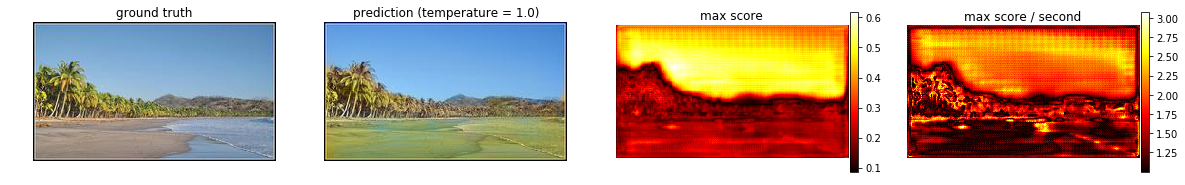

In [18]:
export_confidence(image_paths[1],cd)